In [19]:
pip install opencv-python

   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.6 MB 2.9 MB/s eta 0:00:14
   ---------------------------------------- 0.3/38.6 MB 2.9 MB/s eta 0:00:14
    --------------------------------------- 0.6/38.6 MB 3.5 MB/s eta 0:00:11
    --------------------------------------- 0.8/38.6 MB 4.2 MB/s eta 0:00:09
   - -------------------------------------- 1.1/38.6 MB 4.5 MB/s eta 0:00:09
   - -------------------------------------- 1.3/38.6 MB 4.4 MB/s eta 0:00:09
   - -------------------------------------- 1.4/38.6 MB 4.2 MB/s eta 0:00:09
   - -------------------------------------- 1.5/38.6 MB 4.0 MB/s eta 0:00:10
   - -------------------------------------- 1.6/38.6 MB 3.9 MB/s eta 0:00:10
   - -------------------------------------- 1.8/38.6 MB 3.9 MB/s eta 0:00:10
   -- ------------------------------------- 2.0/38.6 MB 3.9 MB/s eta 0:00:10
   -- ------------------------------------- 2.2/38.6 MB 3.8 MB/s eta 0:00:10
   -- 

In [2]:
import pandas as pd
import numpy as np
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [3]:
import os
os.getcwd()

'c:\\Users\\laura\\OneDrive - Universidad Politécnica de Madrid\\ABC_upm\\VSC\\Information_retrieval\\Assignment2'

In [4]:
# recorrer todas las imagenes de ../data/Fomula_one_cars/Ferrari F1 car

# crear un df con dos columnas: car_id, path

cars_df = pd.DataFrame(columns=['car_id', 'path'])
cars_df

            

,car_id,path


In [5]:
for root, dirs, files in os.walk("..\data\Formula_one_cars\Ferrari"):
    for file in files:
        if file.endswith(".jpg"):
            id = len(cars_df)
            path = os.path.join(root, file)
            cars_df.loc[id] = [id, path]
for root, dirs, files in os.walk("..\data\Formula_one_cars\Alphatauri"):
    for file in files:
        if file.endswith(".jpg"):
            id = len(cars_df)
            path = os.path.join(root, file)
            cars_df.loc[id] = [id, path]
for root, dirs, files in os.walk("..\data\Formula_one_cars\Mclaren"):
    for file in files:
        if file.endswith(".jpg"):
            id = len(cars_df)
            path = os.path.join(root, file)
            cars_df.loc[id] = [id, path]
for root, dirs, files in os.walk("..\data\Formula_one_cars\Mercedes"):
    for file in files:
        if file.endswith(".jpg"):
            id = len(cars_df)
            path = os.path.join(root, file)
            cars_df.loc[id] = [id, path]
for root, dirs, files in os.walk("..\data\Formula_one_cars\Racingpoint"):
    for file in files:
        if file.endswith(".jpg"):
            id = len(cars_df)
            path = os.path.join(root, file)
            cars_df.loc[id] = [id, path]
for root, dirs, files in os.walk("..\data\Formula_one_cars\Redbull"):
    for file in files:
        if file.endswith(".jpg"):
            id = len(cars_df)
            path = os.path.join(root, file)
            cars_df.loc[id] = [id, path]
for root, dirs, files in os.walk("..\data\Formula_one_cars\Williams"):
    for file in files:
        if file.endswith(".jpg"):
            id = len(cars_df)
            path = os.path.join(root, file)
            cars_df.loc[id] = [id, path]
for root, dirs, files in os.walk("..\data\Formula_one_cars\Reanult"):
    for file in files:
        if file.endswith(".jpg"):
            id = len(cars_df)
            path = os.path.join(root, file)
            cars_df.loc[id] = [id, path]

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\d'
<>:43: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\d'
<>:43: SyntaxWarning: invalid escape sequence '\d'
C:\Users\laura\AppData\Local\Temp\ipykernel_15152\3762779341.py:1: SyntaxWarning: invalid escape sequence '\d'
  for root, dirs, files in os.walk("..\data\Formula_one_cars\Ferrari"):
C:\Us

In [6]:
cars_df.head()

,car_id,path
0,0,..\data\Formula_one_cars\Ferrari\00000002.jpg
1,1,..\data\Formula_one_cars\Ferrari\00000003.jpg
2,2,..\data\Formula_one_cars\Ferrari\00000004.jpg
3,3,..\data\Formula_one_cars\Ferrari\00000005.jpg
4,4,..\data\Formula_one_cars\Ferrari\00000006.jpg


In [7]:
cars_df.shape

(1998, 2)

In [8]:
# save the df as a csv
cars_df.to_csv('cars.csv', index=False)

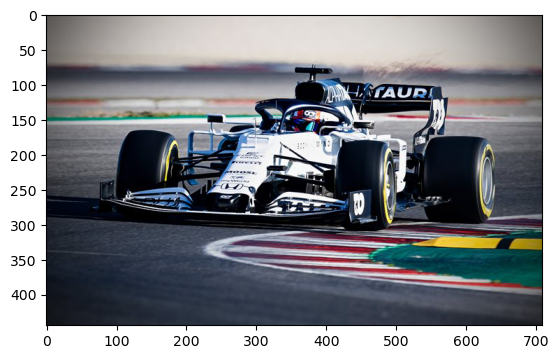

In [78]:
# enseñar por pantalla la imagen de cars_df['path'][0]

from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(cars_df['path'][350])
plt.imshow(img)


In [26]:
import pytesseract

text = pytesseract.image_to_string(img)
text

'y cASPERS IN ‘\n8 N\n\\\n\nFIAT\n\n'

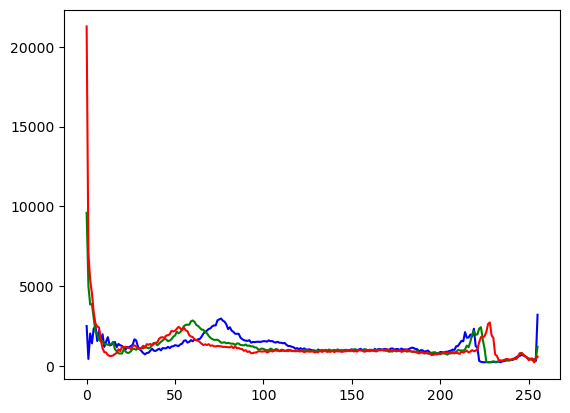

In [80]:
import cv2
image = cv2.imread(cars_df['path'][350])
blue = cv2.calcHist([image], [0], None, [256], [0, 256])
green = cv2.calcHist([image], [1], None, [256], [0, 256])
red = cv2.calcHist([image], [2], None, [256], [0, 256])

plt.plot(blue, color='b')
plt.plot(green, color='g')
plt.plot(red, color='r')

plt.show()


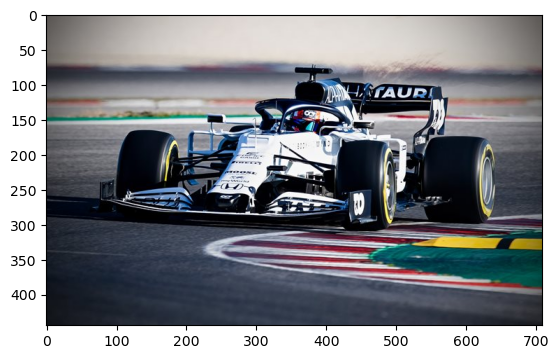

In [81]:
my_img = cv2.imread(cars_df['path'][350]) 
my_img_pah = cars_df['path'][0]
plt.imshow(cv2.cvtColor(my_img, cv2.COLOR_BGR2RGB))
plt.show()


In [82]:
results = []
# iter over the df
for i, img in cars_df.iterrows():
    image = cv2.imread(img['path'])
    if my_img_pah != img['path']:
        # Compare text between my_img and image
        text1 = pytesseract.image_to_string(my_img)
        text2 = pytesseract.image_to_string(image)
        
        words1 = text1.split()
        words2 = text2.split()
        
        # count number of equal words
        count = 0
        for word in words1:
            if word in words2:
                count += 1
                
        if len(words1) == 0 or len(words2) == 0:
            similarity = 0
        else:
            similarity = count / len(words1)
        
        # Color comparison
        blue1 = cv2.calcHist([my_img], [0], None, [256], [0, 256])
        green1 = cv2.calcHist([my_img], [1], None, [256], [0, 256])
        red1 = cv2.calcHist([my_img], [2], None, [256], [0, 256])
        
        blue2 = cv2.calcHist([image], [0], None, [256], [0, 256])
        green2 = cv2.calcHist([image], [1], None, [256], [0, 256])
        red2 = cv2.calcHist([image], [2], None, [256], [0, 256])
        
        # Compare histograms - correlation
        similarity_blue = cv2.compareHist(blue1, blue2, cv2.HISTCMP_CORREL)
        similarity_green = cv2.compareHist(green1, green2, cv2.HISTCMP_CORREL)
        similarity_red = cv2.compareHist(red1, red2, cv2.HISTCMP_CORREL)
        mean_corr = (similarity_blue + similarity_green + similarity_red) / 3
        
        # Compare histograms - intersection
        similarity_blue_i = cv2.compareHist(blue1, blue2, cv2.HISTCMP_INTERSECT)
        similarity_green_i = cv2.compareHist(green1, green2, cv2.HISTCMP_INTERSECT)
        similarity_red_i = cv2.compareHist(red1, red2, cv2.HISTCMP_INTERSECT)
        mean_intersection = (similarity_blue_i + similarity_green_i + similarity_red_i) / 3
        
        results.append([img['path'],0.2*similarity+0.5* mean_corr+0.3*mean_intersection])
    

PermissionError: [WinError 32] El proceso no tiene acceso al archivo porque está siendo utilizado por otro proceso: 'C:\\Users\\laura\\AppData\\Local\\Temp\\tess_7mgpnzsr_input.PNG'

In [83]:
# results to df with two columns car_id, similarity
results_df = pd.DataFrame(results, columns=['path', 'similarity'])
results_df.tail()

,path,similarity
255,..\data\Formula_one_cars\Ferrari\00000416.jpg,85651.118633
256,..\data\Formula_one_cars\Ferrari\00000418.jpg,93649.075855
257,..\data\Formula_one_cars\Ferrari\00000419.jpg,35904.760167
258,..\data\Formula_one_cars\Ferrari\00000420.jpg,85514.721966
259,..\data\Formula_one_cars\Ferrari\00000421.jpg,74401.945041


In [84]:

# sort df by similarity
results_df = results_df.sort_values(by='similarity', ascending=False)
results_df



,path,similarity
22,..\data\Formula_one_cars\Ferrari\00000036.jpg,94572.305338
163,..\data\Formula_one_cars\Ferrari\00000260.jpg,94572.300668
133,..\data\Formula_one_cars\Ferrari\00000202.jpg,94572.267686
192,..\data\Formula_one_cars\Ferrari\00000317.jpg,94572.262204
128,..\data\Formula_one_cars\Ferrari\00000191.jpg,94572.199730
...,...,...
110,..\data\Formula_one_cars\Ferrari\00000165.jpg,28436.592707
91,..\data\Formula_one_cars\Ferrari\00000141.jpg,26453.526564
75,..\data\Formula_one_cars\Ferrari\00000116.jpg,24656.559618
94,..\data\Formula_one_cars\Ferrari\00000145.jpg,24104.853783


In [74]:
results_df.tail()

,path,similarity
101,..\data\Formula_one_cars\Ferrari\00000153.jpg,30638.664530
110,..\data\Formula_one_cars\Ferrari\00000165.jpg,28314.493433
91,..\data\Formula_one_cars\Ferrari\00000141.jpg,26626.295401
75,..\data\Formula_one_cars\Ferrari\00000116.jpg,24497.068212
94,..\data\Formula_one_cars\Ferrari\00000145.jpg,23948.761503


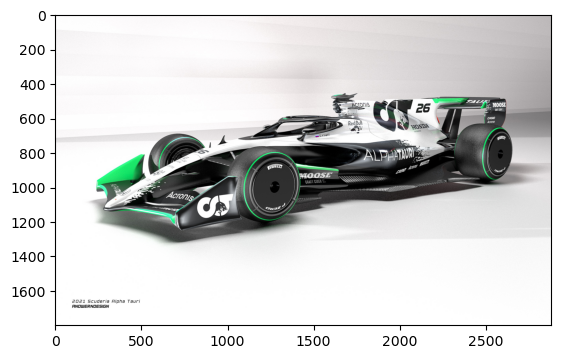

96000.33920980085


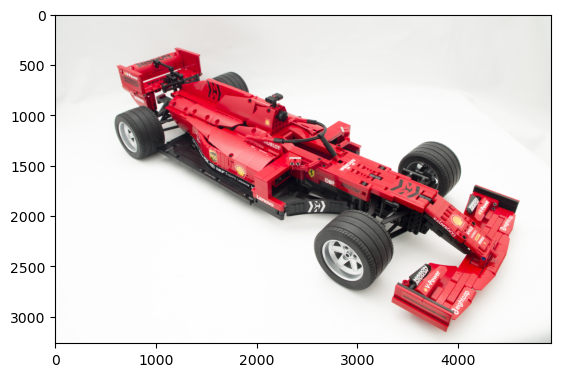

96000.32207523807


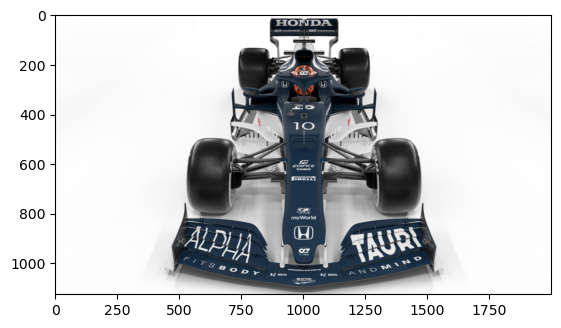

96000.17576354583


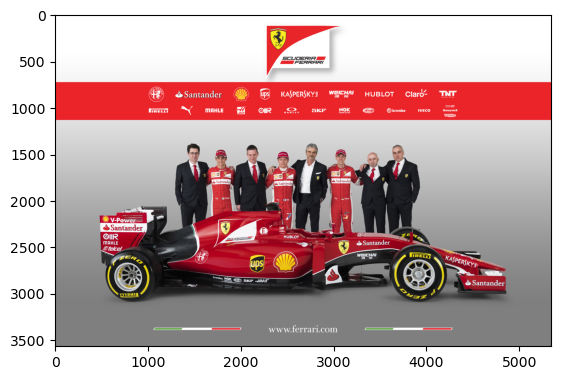

96000.16631255424


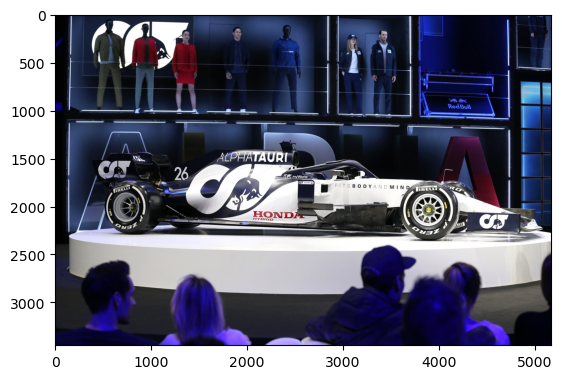

92626.12338330559


In [66]:
# show first 5 images
for i, row in results_df.head().iterrows():
    img = Image.open(row['path'])
    plt.imshow(img)
    plt.show()
    print(row['similarity'])
    
# show last 5 images